# Imports

In [ ]:
from pprint import pprint
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import gensim
import gensim.corpora as corpora
from gensim.corpora import Dictionary
from gensim.utils import simple_preprocess
from gensim.models import LdaModel
from gensim.matutils import corpus2csc
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import re
import string

# import pyLDAvis.gensim
# import pickle
# import pyLDAvis


nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

# Functions

## EDA and preprocessing

In [ ]:
SW_list = ['from', 'subject', 're', 'edu', 'use','el','nio','three','two','also','since','using','thu','related','based','from','several','although','ofthe','inthe','tothe','forthe']
extended_stopwords = stopwords.words('english') + SW_list

In [ ]:
# Make sure to download the necessary NLTK data
def preprocess_text(text: str) -> str:
    """
    Preprocess a given text by removing punctuation, special characters, digits,
    and then lemmatizing all the words.

    Parameters:
    text (str): The input text to be preprocessed.

    Returns:
    str: The preprocessed text.
    """
    cleaned_text = re.sub(r'[^a-zA-Z\s]', '', text)
    cleaned_text = cleaned_text.lower()
    tokens = nltk.word_tokenize(cleaned_text)
    extended_stopwords = stopwords.words('english') + SW_list
    tokens = [word for word in tokens if word not in extended_stopwords and len(word) > 1]
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]
    lemmatized_text = ' '.join(lemmatized_tokens)

    return lemmatized_text



In [ ]:
def advanced_text_eda(df, column_name):
    """
    Perform advanced EDA on a text column in a dataframe.

    :param pd.DataFrame df: The input dataframe
    :param str column_name: The name of the text column to analyze
    """

    # Check for missing values
    missing_values = df[column_name].isnull().sum()
    print(f"Missing values in column '{column_name}': {missing_values}")

    # Text length distribution
    # df['text_length'] = df[column_name].apply(lambda x: len(str(x).split()))
    # plt.figure()
    # sns.histplot(df['text_length'])
    # plt.title('Text Length Distribution')
    # plt.xlabel('Text Length')
    # plt.ylabel('Frequency')
    # plt.show()
    # print('\n\n\n\n')

    # Word cloud of most common words
    all_text = ' '.join(df[column_name].dropna().astype(str))
    wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=set(extended_stopwords), min_font_size=10).generate(all_text)

    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.title('Most Common Words')
    plt.show()
    print('\n\n\n\n')

    # N-gram analysis to identify common phrases
    def get_top_n_grams(corpus, n, g):
        vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0)
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:n]

    common_phrases = get_top_n_grams(df[column_name].dropna().astype(str), 20, 2)
    df_common_phrases = pd.DataFrame(common_phrases, columns=['Phrase', 'Frequency'])

    plt.figure()
    sns.barplot(x='Frequency', y='Phrase', data=df_common_phrases, palette='crest')
    plt.title('Top 20 Bigrams')
    plt.show()

## topic modelling

In [ ]:
def assign_topics_to_dataframe_LDA_V1(df, text_column, n_features=5000, n_topics=30, n_top_words=20):
    """
    Read text data from a pandas DataFrame, perform topic modeling,
    and assign the main topic (most important words) to each text in a new column.

    :param df: Input pandas DataFrame
    :param text_column: Name of the column containing text data
    :param n_features: The maximum number of features (default is 1000)
    :param n_topics: The number of topics to extract (default is 5)
    :param n_top_words: The number of top words to extract for each topic (default is 10)

    :return: DataFrame with additional columns containing the main topic and scores for each text
    """

    tfidf_vectorizer = TfidfVectorizer(max_df=0.8, min_df=2, max_features=n_features, stop_words=extended_stopwords)
    tfidf = tfidf_vectorizer.fit_transform(df[text_column])
    lda = LatentDirichletAllocation(n_components=n_topics, max_iter=5, learning_method='online', learning_offset=50., random_state=1).fit(tfidf)
    tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
    topic_dict = {}
    for topic_idx, topic in enumerate(lda.components_):
        important_features = [tfidf_feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        topic_dict[topic_idx] = ', '.join(important_features)
    topic_assignments = lda.transform(tfidf).argmax(axis=1)
    topic_scores = lda.transform(tfidf)
    df['Main Topic'] = [topic_dict[topic] for topic in topic_assignments]
    df['Topic Scores'] = [list(zip(range(n_topics), scores)) for scores in topic_scores]
    for topic_idx, topic_words in topic_dict.items():
        print(f"Topic #{topic_idx}: {topic_words}")

    return df

In [ ]:
def assign_topics_to_dataframe_LDA_V2(df: pd.DataFrame, text_column: str) -> pd.DataFrame:
    """
    Process the specified text column in a DataFrame, perform topic modeling,
    and return a DataFrame with topics and associated scores for each document.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    text_column (str): The name of the column containing text to be processed and analyzed.

    Returns:
    pd.DataFrame: A DataFrame with topics and associated scores for each document.
    """

    df['Abstract_preprocessed'] = df['text'].apply(preprocess_text)
    df['tokenized_sents'] = df.apply(lambda row: nltk.word_tokenize(row['Abstract_preprocessed']), axis=1)
    dictionary = Dictionary(df['tokenized_sents'])
    dictionary.filter_extremes(no_below=5, no_above=0.5)
    bow_corpus = [dictionary.doc2bow(text) for text in df['tokenized_sents']]
    num_topics = 30
    ldamodel = LdaModel(bow_corpus, num_topics=num_topics, id2word=dictionary, passes=20, alpha='auto', eta='auto')
    topics = ldamodel.show_topics(num_topics=num_topics, num_words=20, log=False, formatted=False)
    for topic_id, topic in topics:
        print(f"Topic: {topic_id}")
        print(f"Words: {[word for word, _ in topic]}")

    topics_data = []
    topics_df = pd.DataFrame(columns=['Document', 'Topic', 'Score'])

    for idx, doc in enumerate(ldamodel[bow_corpus]):
        for topic, score in doc:
              topics_data.append({'Document': idx, 'Topic': topic, 'Score': score})
    topics_df = pd.DataFrame(topics_data)
    merged_df = pd.merge(df, topics_df, left_index=True, right_on='Document')

    return topics_df

In [ ]:
# stop_words = stopwords.words('english')
# stop_words.extend(['from', 'subject', 're', 'edu', 'use','el','nio','three','two','also','since','using','thu','related','based','from','several','although'])
# def sent_to_words(sentences):
#     for sentence in sentences:
#         # deacc=True removes punctuations
#         yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
# def remove_stopwords(texts):
#     return [[word for word in simple_preprocess(str(doc))
#              if word not in stop_words] for doc in texts]
# data = df.Text_preprocessed.values.tolist()
# data_words = list(sent_to_words(data))
# # remove stop words
# data_words = remove_stopwords(data_words)
# # Create Dictionary
# id2word = corpora.Dictionary(data_words)
# # Create Corpus
# texts = data_words
# # Term Document Frequency
# corpus = [id2word.doc2bow(text) for text in texts]
# # number of topics
# num_topics = 30
# # Build LDA model
# lda_model = gensim.models.LdaMulticore(corpus=corpus,
#                                        id2word=id2word,
#                                        num_topics=num_topics)
# pprint(lda_model.print_topics())
# doc_lda = lda_model[corpus]
def assign_topics_to_dataframe_LDAV3(df: pd.DataFrame, text_column: str) -> pd.DataFrame:
    """
    Perform topic modeling on a DataFrame of texts and attach the extracted topics
    to the DataFrame with their respective scores.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    text_column (str): The name of the column containing text to be processed and analyzed.

    Returns:
    pd.DataFrame: The DataFrame with attached topics and scores.
    """
    # Define stopwords
    stop_words = stopwords.words('english')
    stop_words.extend(SW_list)

    # Function to tokenize sentences into words
    def sent_to_words(sentences):
        for sentence in sentences:
            yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

    # Function to remove stopwords
    def remove_stopwords(texts):
        return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

    # Preprocess the data
    data = df[text_column].values.tolist()
    data_words = list(sent_to_words(data))
    data_words = remove_stopwords(data_words)

    # Create Dictionary and Corpus
    id2word = corpora.Dictionary(data_words)
    corpus = [id2word.doc2bow(text) for text in data_words]

    # Build LDA model
    num_topics = 30
    lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=num_topics)

    # Print the topics
    pprint(lda_model.print_topics())
    print('\n\n\n\n')
    topics = lda_model.show_topics(num_topics=num_topics, num_words=30, log=False, formatted=False)
    for topic_id, topic in topics:
        print(f"Topic: {topic_id}")
        print(f"Words: {[word for word, _ in topic]}")


    # Get the topic distribution for each document
    doc_lda = lda_model[corpus]

    # Prepare a DataFrame to hold the topics and scores for each document
    # topics_df = pd.DataFrame(columns=['Document', 'Topic', 'Score'])
    topics_data = []

    # Populate the topics_df DataFrame with topics and scores
    for idx, doc in enumerate(doc_lda):
        for topic, score in doc:
            topics_data.append({'Document': idx, 'Topic': topic, 'Score': score})

    # Merge the topics_df DataFrame with the original DataFrame
    topics_df = pd.DataFrame(topics_data)
    merged_df = pd.merge(df, topics_df, left_index=True, right_on='Document')

    return merged_df


In [ ]:
def assign_topics_to_dataframe_NMF(df, text_column, n_features=5000, n_topics=30, n_top_words=20):
    """
    Read text data from a pandas DataFrame, perform topic modeling using NMF,
    and assign the main topic (most important words) and topic scores to each text in new columns.

    :param df: Input pandas DataFrame
    :param text_column: Name of the column containing text data
    :param n_features: The maximum number of features (default is 1000)
    :param n_topics: The number of topics to extract (default is 5)
    :param n_top_words: The number of top words to extract for each topic (default is 10)

    :return: DataFrame with additional columns containing the main topic and scores for each text
    """

    tfidf_vectorizer = TfidfVectorizer(max_df=0.8, min_df=2, max_features=n_features, stop_words=extended_stopwords)
    tfidf = tfidf_vectorizer.fit_transform(df[text_column])
    nmf = NMF(n_components=n_topics, random_state=1, max_iter=10000).fit(tfidf)
    tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
    topic_dict = {}
    for topic_idx, topic in enumerate(nmf.components_):
        important_features = [tfidf_feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        topic_dict[topic_idx] = ', '.join(important_features)
    topic_assignments = nmf.transform(tfidf).argmax(axis=1)
    topic_scores = nmf.transform(tfidf)

    df['Main Topic'] = [topic_dict[topic] for topic in topic_assignments]
    for i in range(n_topics):
        df[f'Topic {i} Score'] = topic_scores[:, i]
    for topic_idx, topic_words in topic_dict.items():
        print(f"Topic #{topic_idx}: {topic_words}")

    return df

## Visualize

# Main

In [ ]:
df = pd.read_csv('/content/FinalCorpus2.csv')
df.head()

,Generated_Name,text
0,ATCM45_ip001_e.docx,report by the cep observer to the xxxvii scar ...
1,ATCM45_ip002_e.docx,report by the ccamlr observer to the forty fif...
2,ATCM45_ip003_rev1_e.docx,report by the united kingdom as depositary gov...
3,ATCM45_ip004_e.docx,report of the depositary government of the ant...
4,ATCM45_ip005_e.docx,republic of belarus in the systemof the antarc...


In [ ]:
df['Text_preprocessed'] = df['text'].apply(preprocess_text)

In [ ]:
df.head()

,Generated_Name,text,Text_preprocessed
0,ATCM45_ip001_e.docx,report by the cep observer to the xxxvii scar ...,report cep observer xxxvii scar delegate meeti...
1,ATCM45_ip002_e.docx,report by the ccamlr observer to the forty fif...,report ccamlr observer forty fifth antarctic t...
2,ATCM45_ip003_rev1_e.docx,report by the united kingdom as depositary gov...,report united kingdom depositary government co...
3,ATCM45_ip004_e.docx,report of the depositary government of the ant...,report depositary government antarctic treaty ...
4,ATCM45_ip005_e.docx,republic of belarus in the systemof the antarc...,republic belarus systemof antarctic treaty jus...


Missing values in column 'Text_preprocessed': 0


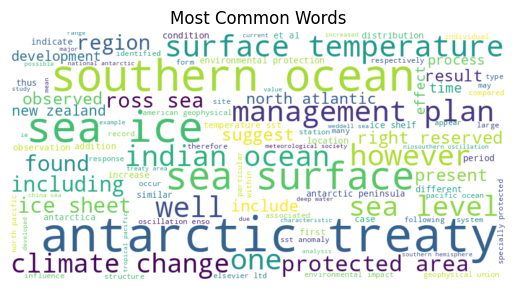

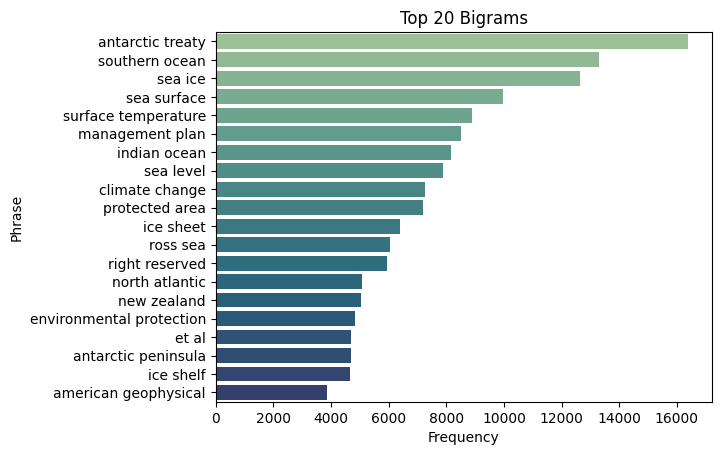

In [ ]:
advanced_text_eda(df, 'Text_preprocessed')

## Text Results

In [ ]:
df_NMF = assign_topics_to_dataframe_NMF(df,'Text_preprocessed')

Topic #0: variability, mode, trend, interannual, oscillation, decadal, index, temperature, climate, sea, variation, pattern, analysis, scale, time, year, period, level, correlation, data
Topic #1: antarctic, research, station, scientific, polar, science, antarctica, scar, program, project, international, national, data, climate, programme, expedition, system, scientist, activity, institute
Topic #2: activity, tourism, iaato, site, vessel, environmental, operator, impact, ship, atcm, guideline, tourist, information, station, season, non, passenger, operation, party, visitor
Topic #3: ice, sea, sheet, antarctic, thickness, arctic, snow, glacier, extent, ross, retreat, melting, cover, antarctica, melt, seaice, stream, loss, pack, weddell
Topic #4: specie, genus, sp, new, nov, specimen, described, family, distribution, known, collected, diversity, taxon, sea, assemblage, fauna, depth, morphological, group, deepsea
Topic #5: basin, fault, margin, seismic, crust, plate, km, zone, ridge, late

In [ ]:
df_LDAV1 = assign_topics_to_dataframe_LDA_V1(df,'Text_preprocessed')

Topic #0: metal, concentration, pahs, congener, pcbs, ng, compound, hydrocarbon, contamination, contaminant, sample, lipid, pcb, pop, pollutant, liver, tissue, ddt, pah, pollution
Topic #1: road, runway, work, site, boulder, lichen, ai, fig, construction, proposed, imo, gravel, italian, sr, zucchelli, impact, mario, guideline, clay, safety
Topic #2: iaato, antarctic, group, ambassador, threat, outreach, strategy, education, specie, terrestrial, benefit, biodiversity, management, climate, committee, concept, managing, working, antarctica, status
Topic #3: hca, iho, charting, captain, inspection, ferraz, chart, antarctic, hydrographic, portal, treaty, station, clothing, team, editorial, inspected, party, survey, atcm, article
Topic #4: belarus, republic, camlr, antarctic, scientific, committee, sc, treaty, activity, ccamlr, station, ipy, monitoring, research, international, network, polar, seismic, plan, krill
Topic #5: specie, genus, population, sp, island, penguin, habitat, seal, speci

In [ ]:
df_LDAV2 = assign_topics_to_dataframe_LDA_V2(df,'Text_preprocessed')

Topic: 0
Words: ['bob', 'nd', 'tp', 'sic', 'ar', 'io', 'ce', 'dic', 'sa', 'h', 'sat', 'th', 'ea', 'sie', 's', 't', 'fco', 'ssa', 'oa', 'ot']
Topic: 1
Words: ['thailand', 'vietnam', 'malaysia', 'eep', 'bt', 'ban', 'paint', 'residency', 'referenced', 'geo', 'whelk', 'identifier', 'tbt', 'antifouling', 'artist', 'broaden', 'polygon', 'aq', 'tributyltin', 'associating']
Topic: 2
Words: ['change', 'climate', 'warming', 'trend', 'global', 'increase', 'temperature', 'level', 'response', 'sc', 'year', 'future', 'increased', 'decade', 'effect', 'shift', 'impact', 'century', 'decrease', 'regional']
Topic: 3
Words: ['australia', 'new', 'zealand', 'australian', 'united', 'antarctic', 'state', 'antarctica', 'u', 'government', 'kingdom', 'resource', 'argentina', 'south', 'argentine', 'work', 'consultative', 'africa', 'ob', 'mr']
Topic: 4
Words: ['type', 'domain', 'classification', 'category', 'classified', 'cave', 'classify', 'wilderness', 'free', 'fecundity', 'linnaeus', 'map', 'seascape', 'systema

In [ ]:
df_LDAV3 = assign_topics_to_dataframe_LDAV3(df, 'Text_preprocessed')

[(7,
  '0.008*"weichselian" + 0.006*"malaria" + 0.005*"eca" + 0.003*"controller" + '
  '0.002*"agglomeration" + 0.002*"antarctic" + 0.002*"interstadials" + '
  '0.002*"balkan" + 0.002*"tae" + 0.002*"marsili"'),
 (5,
  '0.097*"ice" + 0.024*"sea" + 0.022*"antarctic" + 0.018*"shelf" + '
  '0.015*"sheet" + 0.009*"antarctica" + 0.009*"glacier" + 0.007*"melt" + '
  '0.007*"melting" + 0.006*"change"'),
 (6,
  '0.038*"dfe" + 0.026*"en" + 0.018*"de" + 0.006*"su" + 0.005*"caudal" + '
  '0.004*"asi" + 0.004*"la" + 0.004*"que" + 0.003*"para" + 0.003*"nacional"'),
 (22,
  '0.014*"specie" + 0.014*"population" + 0.011*"sea" + 0.009*"fish" + '
  '0.008*"southern" + 0.007*"study" + 0.007*"habitat" + 0.006*"marine" + '
  '0.006*"area" + 0.006*"distribution"'),
 (26,
  '0.040*"fishery" + 0.030*"fishing" + 0.014*"catch" + 0.014*"management" + '
  '0.012*"area" + 0.010*"stock" + 0.010*"conservation" + 0.009*"bycatch" + '
  '0.009*"tuna" + 0.009*"marine"'),
 (18,
  '0.010*"island" + 0.009*"area" + 0.008*"fa

In [ ]:
df_LDAV1.to_csv('/content/LDAV1.csv')
df_LDAV2.to_csv('/content/LDAV2.csv')
df_LDAV3.to_csv('/content/LDAV3.csv')
df_NMF.to_csv('/content/NMF.csv')